# Simple iteration for systems of linear equations

First, generate a random diagonally dominant matrix, for testing.

In [127]:
import numpy as np
rndm = np.random.RandomState(1234)

n = 10
A = rndm.uniform(size=(n, n)) + np.diagflat([15]*n)
b = rndm.uniform(size=n)

# I.  Jacobi iteration

Given

$$
A x = b
$$

separate the diagonal part $D$,

$$ A = D + (A - D) $$

and write

$$
x = D^{-1} (D - A) x + D^{-1} b\;.
$$

Then iterate

$$
x_{n + 1} = B x_{n} + c\;,
$$

where 

$$
B = D^{-1} (A - D) \qquad \text{and} \qquad c = D^{-1} b
$$


Let's construct the matrix and the r.h.s. for the Jacobi iteration

In [128]:
diag_1d = np.diag(A)

B = -A.copy()
np.fill_diagonal(B, 0)

D = np.diag(diag_1d)
invD = np.diag(1./diag_1d)
BB = invD @ B 
c = invD @ b

In [129]:
# sanity checks
from numpy.testing import assert_allclose

assert_allclose(-B + D, A)


# xx is a "ground truth" solution, compute it using a direct method
xx = np.linalg.solve(A, b)

np.testing.assert_allclose(A@xx, b)
np.testing.assert_allclose(D@xx, B@xx + b)
np.testing.assert_allclose(xx, BB@xx + c)

Check that $\| B\| \leqslant 1$:

In [130]:
np.linalg.norm(BB)

0.36436161983015336

### Do the Jacobi iteration

In [131]:
n_iter = 50

x0 = np.ones(n)
x = x0
for _ in range(n_iter):
    x = BB @ x + c

In [132]:
# Check the result:

A @ x - b

array([ 0.00000000e+00,  2.22044605e-16,  0.00000000e+00, -1.11022302e-16,
        0.00000000e+00,  0.00000000e+00, -2.08166817e-17,  0.00000000e+00,
        0.00000000e+00,  2.22044605e-16])

### Task I.1

Collect the proof-of-concept above into a single function implementing the Jacobi iteration. This function should receive the r.h.s. matrix $A$, the l.h.s. vector `b`, and the number of iterations to perform.


The matrix $A$ in the illustration above is strongly diagonally dominant, by construction. 
What happens if the diagonal matrix elements of $A$ are made smaller? Check the convergence of the Jacobi iteration, and check the value of the norm of $B$.

(20% of the total grade)


In [151]:
def Jacobi_iter_function(A, b, n_iter = 1000):
    diag_1d = np.diag(A)

    B = -A.copy()
    np.fill_diagonal(B, 0)
 
    D = np.diag(diag_1d)         # матрица диагоналей
    invD = np.diag(1./diag_1d)
    BB = invD @ B                # обратная к D умноженная на A
    c = invD @ b                 # обратная к D на вектор b

    x0 = np.ones(n)              # начальное условие, скорее всего будет работать не во всех случаях
    x = x0
    
    for _ in range(n_iter):     # итерации
        x = BB @ x + c
        
    return A @ x - b

In [152]:
print(Jacobi_iter_function(A, b, n_iter))

[-1.11022302e-16  1.11022302e-16  0.00000000e+00]


# II. Seidel's iteration.

##### Task II.1

Implement the Seidel's iteration. 

Test it on a random matrix. Study the convergence of iterations, relate to the norm of the iteration matrix.

(30% of the total grade)

In [153]:
from math import sqrt
import numpy as np

def seidels_iteration(A, b, n_iter = 1000):
  
    x = np.zeros(len(A))
    
    for i in range(n_iter):         # просто количество итераций
                                  
        for j in range(len(A)):    # просто бежим по столбцам/строкам матрицы
            
            x[j] = (b[j] - A[j] @ x + A[j][j] * x[j]) / A[j][j]  # формула для итерации Зейделя

    return x

In [154]:
print(seidels_iteration(A, b, n_iter))

[0.23593501 0.15448393 0.10190892]


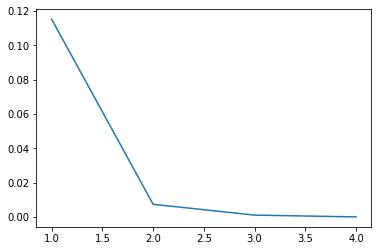

In [155]:
import matplotlib.pyplot as plt
plt.figure()
x = [i for i in range(1,5)]
plt.plot(x, [np.linalg.norm(A @ seidels_iteration(A, b, i) - b) for i in x]) # норма ошибки, при i числе итераций
plt.show()

# III. Minimum residual scheme

### Task III.1

Implement the $\textit{minimum residual}$ scheme: an explicit non-stationary method, where at each step you select the iteration parameter $\tau_n$ to minimize the residual $\mathbf{r}_{n+1}$ given $\mathbf{r}_n$. Test it on a random matrix, study the convergence to the solution, in terms of the norm of the residual and the deviation from the ground truth solution (which you can obtain using a direct method). Study how the iteration parameter $\tau_n$ changes as iterations progress.

(50% of the grade)

In [159]:
def residual(A, b, x0, eps = 1e-5, maxiter = 1000):
    count = 0
    x1 = np.zeros(len(A))
    
    while count < maxiter and abs(np.linalg.norm(x1 - x0)) > eps:   # условия остановки: число итераций, погрешность
        x1 = x0.copy()
        r = A @ x0 - b      # r - значит residual
        t = (r @ (A @ r)) / np.linalg.norm(A @ r)**2   # параметр дзета
    
        x0 = x1 - t * r
        count += 1
    return x0
        

In [160]:
n = 3
A = rndm.uniform(size=(n, n)) + np.eye(n)*2
b = rndm.uniform(size=n)

In [161]:
x0 = np.ones(len(b))

print(residual(A,b,x0))

[0.38271856 0.2262386  0.05427377]


In [183]:
def residual_tests(A, b, x0, eps = 1e-5, maxiter = 1000): # функция для проверки сходимости
    count = 0
    x1 = np.zeros(len(A))
    s = []
    step = []
    while count < maxiter and abs(np.linalg.norm(x1 - x0)) > eps:   # условия остановки: число итераций, погрешность
        x1 = x0.copy()
        r = A @ x0 - b      # r - значит residual
        s.append(np.linalg.norm(r))
        step.append(count)
        t = (r @ (A @ r)) / np.linalg.norm(A @ r)**2   # параметр дзета
        
        x0 = x1 - t * r
        count += 1
    plt.figure()
    plt.plot(step, s)

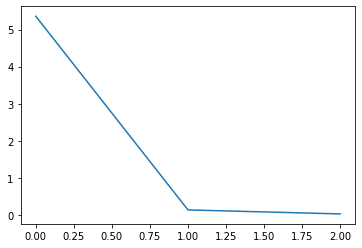

In [184]:
residual_tests(A, b, x0, maxiter = 3)

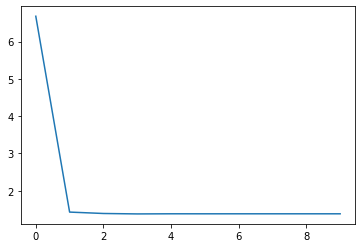

In [186]:
# проверка сходимости без дополнительной функции

step = [i for i in range(10)]
plt.figure()
plt.plot(step, [np.linalg.norm(A @ residual(A, b, x0, maxiter = i)) for i in step])
plt.show()